# Figures

- Figures produced from participant data

In [1]:
import json
#Pandas for saving datasets
import pandas as pd
#matplotlib for rendering
import matplotlib.pyplot as plt
#numpy for handeling matrix operations
import numpy as np
#time, to, well... keep track of time
import time
#iPython display for making sure we can render the frames
from IPython import display
#seaborn for rendering
import seaborn
import math
import os
import statistics as stat
import glob
import seaborn as sns
import matplotlib.ticker as mticker

#code from scipy documentation
from scipy.stats import t
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

/Users/isaacchristian/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Load Data

In [11]:
# Get data file names
cur_path = os.getcwd()
filenames = glob.glob(cur_path + "/data/*.csv")
# Read dframes into a list
dfs = []
for filename in filenames:
    dfs.append(pd.read_csv(filename))

# Filter

In [12]:
# get first dataframe and filter columns

filt_dfs = []
x = []
all_data = []
# concat all dframes into one dframe
for d in dfs:
    my_df = d.filter(items=['congruent', 'Rand Tim', 'key_resp.rt','block_num'])
    # drop na, only 10s
    filt_dfs.append(my_df.dropna())
    x.append(len(my_df.dropna(subset = ['congruent'])) - len(my_df.dropna(subset = ['key_resp.rt'])))
    all_data.append(my_df.dropna(subset=['block_num']))

## concat #
full_dat = pd.concat(filt_dfs)
all_data = pd.concat(all_data)
#x_dat = pd.concat(x)


In [13]:
full_dat

congruent  Rand Tim  key_resp.rt block_num
1          0.0    1.3132     0.636110        5s
2          1.0    0.7037     0.709031        5s
3          0.0    0.8309     0.434464        5s
4          1.0    4.6764     0.553009        5s
5          0.0    4.6441     0.518856        5s
..         ...       ...          ...       ...
416        1.0    4.1302     0.473883        5s
419        0.0    4.1825     0.864461        5s
420        0.0    3.5785     0.386026        5s
421        0.0    1.9596     0.395578        5s
422        0.0    1.5706     0.367873        5s

[9350 rows x 4 columns]

# Misses

In [6]:
count = [i / 400 for i in x] ## 400 is the number of trials
print(f'average misses: {np.mean(count)}')

average misses: 0.10096153846153845


In [6]:
print(f'num subs: {len(dfs)}')

num subs: 26


In [62]:
running_totals = pd.DataFrame(columns=['block_num', 'NaNs for congruent = 1.0', 'NaNs for congruent = 0.0'])

# Iterate over the list of DataFrames
for d in dfs:
    # Filter relevant columns
    my_df = d.filter(items=['congruent', 'Rand Tim', 'key_resp.rt', 'block_num'])

    # Drop rows with NaN in 'block_num'
    df = my_df.dropna(subset=['block_num'])

    # Group by block_num and calculate NaNs for congruent = 1.0 and congruent = 0.0
    nan_counts = df.groupby('block_num').apply(lambda group: pd.Series({
        'NaNs for congruent = 1.0': group[(group['congruent'] == 1.0) & (group['key_resp.rt'].isna())].shape[0],
        'NaNs for congruent = 0.0': group[(group['congruent'] == 0.0) & (group['key_resp.rt'].isna())].shape[0]
    }))

    # Reset index for better readability
    nan_counts = nan_counts.reset_index()

    # Merge with running totals, summing the counts
    running_totals = pd.concat([running_totals, nan_counts]).groupby('block_num', as_index=False).sum()
    
    #print(f'Proportion - valid / invalid: {}')


    #print(f"Updated Running Totals:")
    #print(running_totals)
running_totals

block_num NaNs for congruent = 1.0 NaNs for congruent = 0.0
0       10s                       92                      328
1        1s                       23                      102
2        3s                       46                      181
3        5s                       56                      222

### count of misses

In [23]:
sns.set(style='white')
sns.set_context("poster")

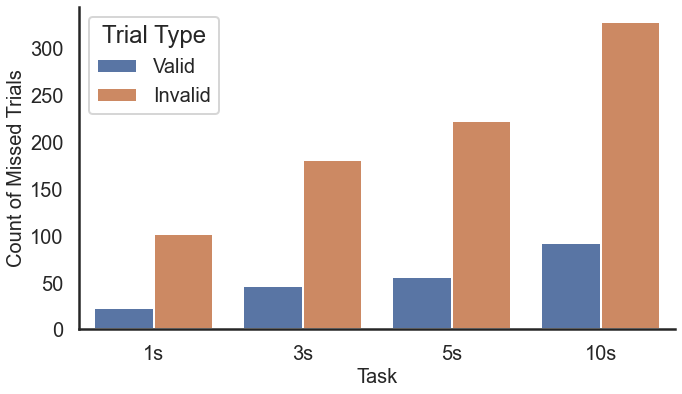

In [30]:
df = pd.DataFrame(running_totals)


# Sort the DataFrame by block_num in the desired order
desired_order = ['1s', '3s', '5s', '10s']
df['block_num'] = pd.Categorical(df['block_num'], categories=desired_order, ordered=True)
df = df.sort_values('block_num')

# Melt the DataFrame for Seaborn compatibility
df_melted = df.melt(id_vars='block_num', 
                    value_vars=['NaNs for congruent = 1.0', 'NaNs for congruent = 0.0'], 
                    var_name='Congruency', 
                    value_name='Count')

# Replace long labels with shorter ones
df_melted['Congruency'] = df_melted['Congruency'].replace({
    'NaNs for congruent = 1.0': 'Valid',
    'NaNs for congruent = 0.0': 'Invalid'
})

# Create the barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='block_num', y='Count', hue='Congruency')

# Customize the plot
#plt.title('NaNs by Congruency and Block', fontsize=14)
plt.xlabel('Task', fontsize=20)
plt.ylabel('Count of Missed Trials', fontsize=20)
plt.legend(title='Trial Type', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.despine()

# Show the plot
plt.tight_layout()
sns.despine()
plt.show()

### Error rate

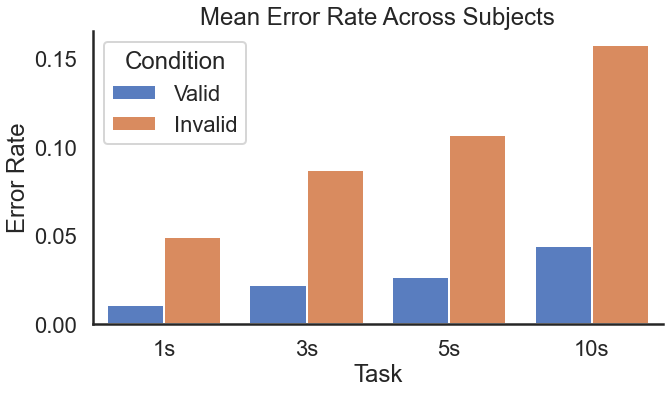

In [60]:
# Calculate the mean and standard error for both conditions
summary_df = (
    merged_df.groupby('block_num')
    .agg(
        mean_congruent_1=('NaNs for congruent = 1.0', 'mean'),
        sem_congruent_1=('NaNs for congruent = 1.0', 'sem'),
        mean_congruent_0=('NaNs for congruent = 0.0', 'mean'),
        sem_congruent_0=('NaNs for congruent = 0.0', 'sem'),
    )
    .reset_index()
)

# Melt the DataFrame for easier plotting with seaborn
melted_df = pd.melt(
    summary_df,
    id_vars='block_num',
    value_vars=['mean_congruent_1', 'mean_congruent_0'],
    var_name='Condition',
    value_name='Mean',
)

# Extract error bars into a separate column
melted_df['Error'] = melted_df['Condition'].map(
    {
        'mean_congruent_1': summary_df['sem_congruent_1'].values,
        'mean_congruent_0': summary_df['sem_congruent_0'].values,
    }
)

# Replace condition names for better labels
melted_df['Condition'] = melted_df['Condition'].replace(
    {'mean_congruent_1': 'Valid', 'mean_congruent_0': 'Invalid'}
)

# Sort block_num for better plotting order
melted_df['block_num'] = pd.Categorical(
    melted_df['block_num'], categories=['1s', '3s', '5s', '10s'], ordered=True
)



# Create the bar plot with seaborn
plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    data=melted_df,
    x='block_num',
    y='Mean',
    hue='Condition',
    ci=None,  # Disable automatic error bars
    palette='muted',
)

# Add error bars manually
'''
for i, row in melted_df.iterrows():
    # Get the correct x and y for each bar
    bar = barplot.patches[i]
    condition = row['Condition']
    error = row['Error']
    
    # Get the x and y position for the error bar
    bar_x = bar.get_x() + bar.get_width() / 2  # X position of the bar
    bar_y = bar.get_height()  # Y position of the bar
    
    # Plot the error bar
    plt.errorbar(
        x=bar_x,
        y=bar_y,
        yerr=error,  # Set the error bar length
        fmt='none',  # No marker for the error bar
        c='black',  # Error bar color
        capsize=5,  # Cap size for error bar
    )
'''
# Customize the plot
plt.title("Mean Error Rate Across Subjects")
plt.ylabel("Error Rate")
plt.xlabel("Task")
plt.legend(title="Condition")
plt.tight_layout()
sns.despine()

# Show the plot
plt.show()

## misses over time

In [79]:
all_data[np.isnan(all_data['key_resp.rt'])]


congruent  Rand Tim  key_resp.rt block_num
62         0.0    5.0639          NaN       10s
89         0.0    1.8365          NaN        5s
105        1.0    4.5400          NaN        5s
147        0.0    5.4343          NaN       10s
181        1.0    3.5822          NaN       10s
..         ...       ...          ...       ...
409        1.0    4.8745          NaN        5s
414        0.0    4.7959          NaN        5s
417        0.0    2.2538          NaN        5s
418        0.0    0.8377          NaN        5s
423        1.0    3.5339          NaN        5s

[1050 rows x 4 columns]

### all

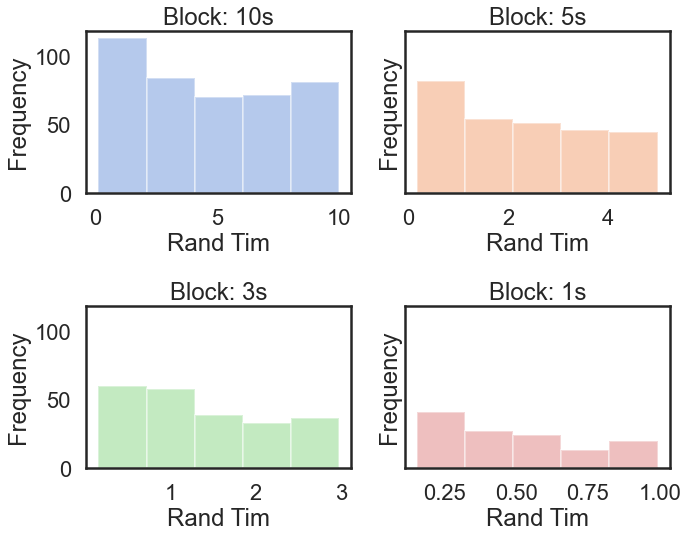

In [90]:
# get all misses
df = all_data[np.isnan(all_data['key_resp.rt'])]

# set binz
binz = 5


# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)

# Define unique block categories and colors
categories = df["block_num"].unique()
colors = sns.color_palette("muted", len(categories))

# Flatten axes array for easier indexing
axes = axes.flatten()

# Plot each histogram in its respective subplot
for ax, block, color in zip(axes, categories, colors):
    sns.distplot(
        df[df["block_num"] == block]["Rand Tim"],
        kde=False,  # No kernel density estimation
        bins=binz,  # Adjust bins as needed
        color=color,
        ax=ax,
    )
    ax.set_title(f"Block: {block}")
    ax.set_xlabel("Rand Tim")
    ax.set_ylabel("Frequency")

# Remove any unused subplots
if len(categories) < len(axes):
    for ax in axes[len(categories):]:
        ax.set_visible(False)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### invalid versus valid

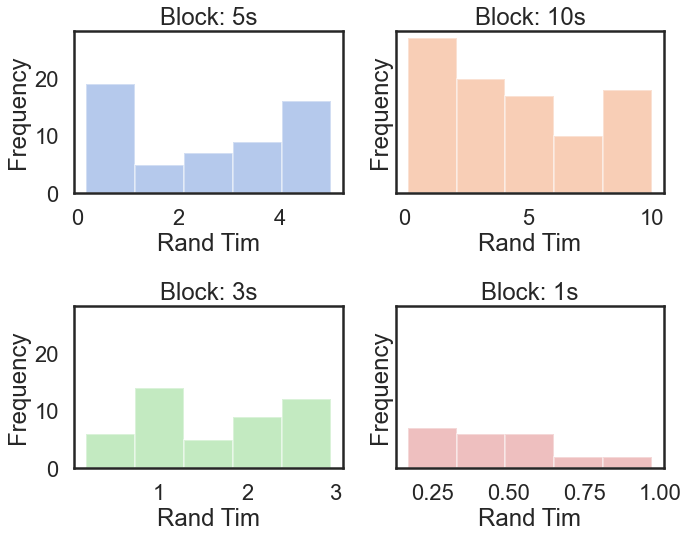

In [91]:
# get all misses
df = all_data[np.isnan(all_data['key_resp.rt'])]
# get invalid or valid
df = df[df['congruent'] == 1.0]
# set binz
binz = 5


# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)

# Define unique block categories and colors
categories = df["block_num"].unique()
colors = sns.color_palette("muted", len(categories))

# Flatten axes array for easier indexing
axes = axes.flatten()

# Plot each histogram in its respective subplot
for ax, block, color in zip(axes, categories, colors):
    sns.distplot(
        df[df["block_num"] == block]["Rand Tim"],
        kde=False,  # No kernel density estimation
        bins=binz,  # Adjust bins as needed
        color=color,
        ax=ax,
    )
    ax.set_title(f"Block: {block}")
    ax.set_xlabel("Rand Tim")
    ax.set_ylabel("Frequency")

# Remove any unused subplots
if len(categories) < len(axes):
    for ax in axes[len(categories):]:
        ax.set_visible(False)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# By task

In [11]:
sns.set(style='white')
sns.set_context("poster")


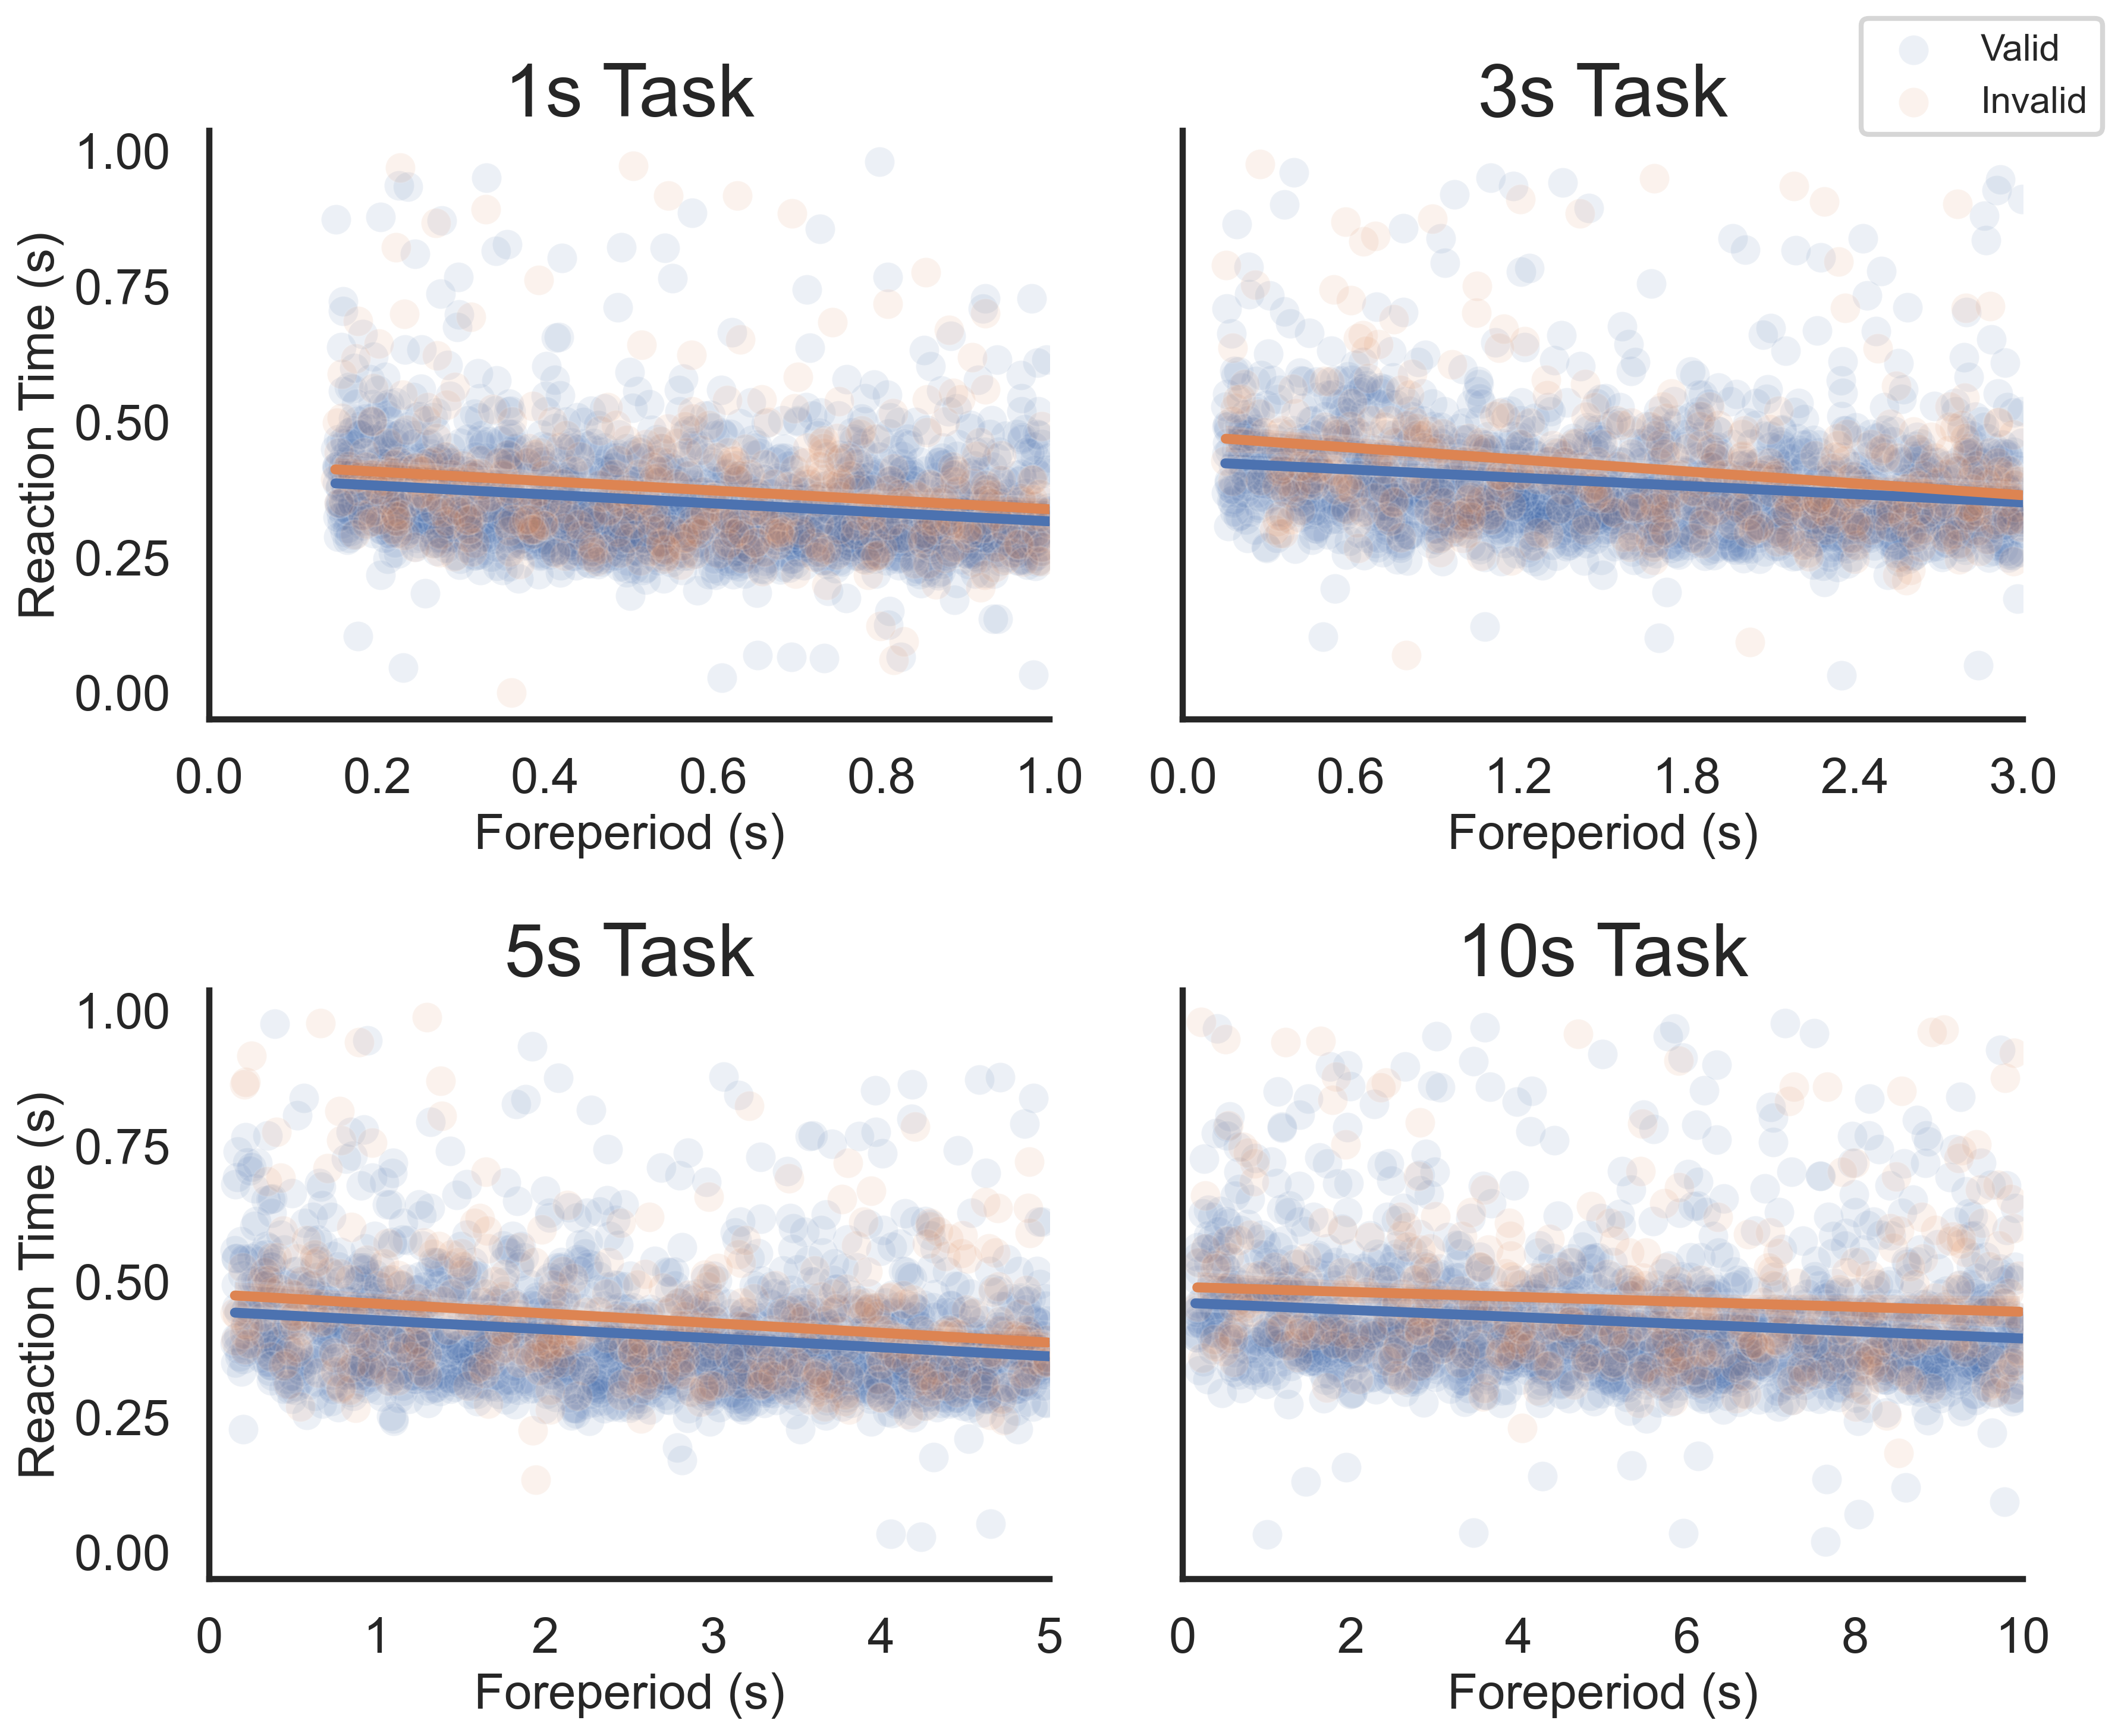

In [12]:
# Create a 2x2 subplot grid for each target condition number
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True, dpi=300)

min_log_rt_threshold = -2.0  # Example threshold, adjust as needed


# Iterate over each target condition number
for i, targ_cond_num in enumerate([1, 3, 5, 10]):
    targ_cond_str = str(targ_cond_num) + 's'
    data = full_dat[full_dat['block_num'] == targ_cond_str]
    
    # Filter out small log(RT) values below the threshold
    data = data[data['key_resp.rt'] >= min_log_rt_threshold]


    row = i // 2  # Calculate the row index
    col = i % 2   # Calculate the column index

    # Scatter plot for congruent == 0 (Valid)
    sns.scatterplot(data=data[data['congruent'] == 0], x='Rand Tim', y='key_resp.rt', alpha=0.1, 
                    ax=axes[row, col], label='Valid', legend=False)
    sns.regplot(data=data[data['congruent'] == 0], x='Rand Tim', y='key_resp.rt', scatter=False, 
                ax=axes[row, col], line_kws={"linewidth": 4})

    # Scatter plot for congruent == 1 (Invalid)
    sns.scatterplot(data=data[data['congruent'] == 1], x='Rand Tim', y='key_resp.rt', alpha=0.1, 
                    ax=axes[row, col], label='Invalid', legend=False)
    sns.regplot(data=data[data['congruent'] == 1], x='Rand Tim', y='key_resp.rt', scatter=False, 
                ax=axes[row, col], line_kws={"linewidth": 4})

    # Set title and labels
    axes[row, col].set_title(f'{targ_cond_num}s Task', fontsize=30)
    axes[row, col].set_xlabel('Foreperiod (s)', fontsize=20)
    axes[row, col].set_ylabel('Reaction Time (s)', fontsize=20)
    
    axes[row, col].tick_params(axis='x', labelsize=20)
    axes[row, col].tick_params(axis='y', labelsize=20)

    # Set x-ticks using np.arange with 5 divisions, including the endpoint
    x_ticks = np.arange(0, targ_cond_num + targ_cond_num / 5, step=targ_cond_num / 5)
    axes[row, col].set_xticks(x_ticks)

# Add the global legend with handles and labels from the last subplot
handles, labels = axes[row, col].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=15)

# Adjust layout and display
plt.tight_layout()
sns.despine()
plt.savefig('fig1_Intervals_with_single_legend.png')
plt.show()


# Across task

In [34]:
sns.set(style='white', font_scale=2.2)

In [35]:
data= full_dat[full_dat['congruent']==0]

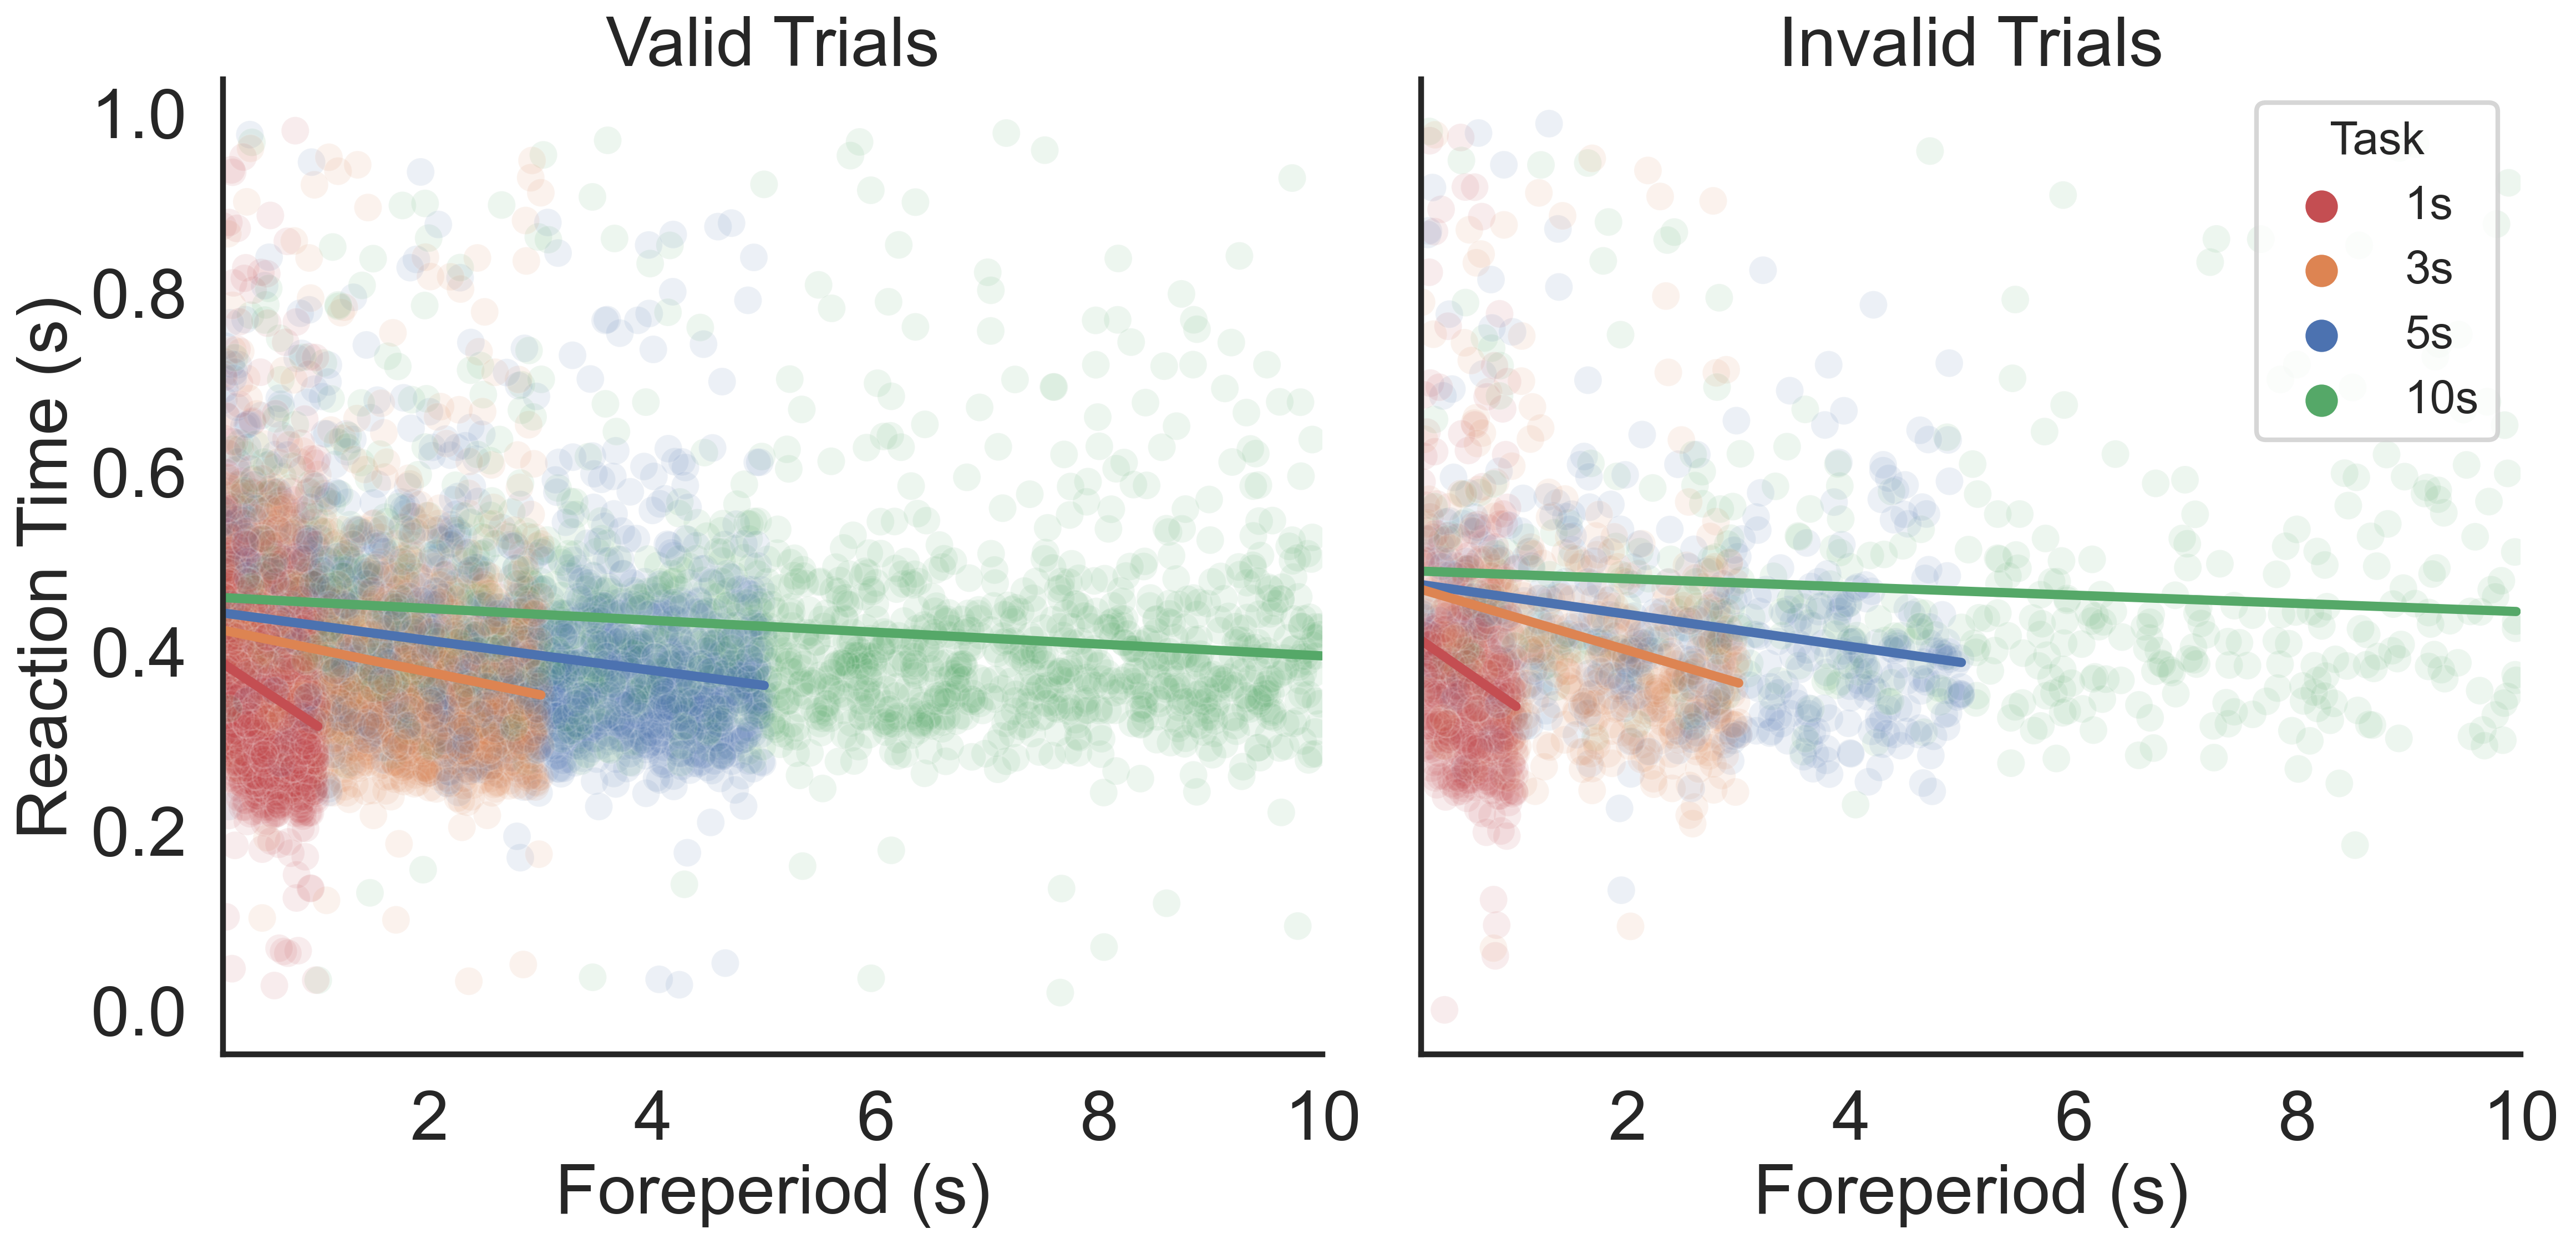

In [6]:
# Set plot size and font sizes
s1 = 30
s2 = 20
sns.set(style='white')
sns.set_context("poster")


# Create two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True, dpi=300)

legend_order = [1, 3, 5, 10]

min_log_rt_threshold = -2


# Iterate over the unique 'congruent' values (0 and 1)
for i, congruent_value in enumerate([0, 1]):
    if congruent_value == 1:
        l = 'Invalid Trials'
    else:
        l = 'Valid Trials'
    # Subset data for the current 'congruent' value
    data = full_dat[full_dat['congruent'] == congruent_value]
    
    # Filter out small log(RT) values below the threshold
    data = data[data['key_resp.rt'] >= min_log_rt_threshold]
    
    # Create the seaborn regplot on the corresponding axis
    sns.scatterplot(data=data, x='Rand Tim', y='key_resp.rt', hue='block_num', alpha=0.1, ax=axes[i])
    # Plot separate regression lines for each 'block_num'
    for block in data['block_num'].unique():
        block_data = data[data['block_num'] == block]
        sns.regplot(data=block_data, x='Rand Tim', y='key_resp.rt', scatter=False, ax=axes[i], 
                    line_kws={"linewidth": 4}, label=f'Block {block} s', ci=None)

    # Set titles and labels for the current plot
    axes[i].set_title(f'{l}', fontsize=s1)
    axes[i].set_xlabel('Foreperiod (s)', fontsize=s1)

    # Set tick label sizes for x and y axes
    axes[i].tick_params(axis='x', labelsize=s1)
    axes[i].tick_params(axis='y', labelsize=s1)
    
    axes[i].set_xticks([2, 4, 6, 8, 10])

# Set a common y-axis label for both subplots
axes[0].set_ylabel('Reaction Time (s)', fontsize=s1)

# Customize the legend for the second subplot (axes[1])
handles, labels = axes[1].get_legend_handles_labels()
ordered_handles = [handles[labels.index(f'{block}s')] for block in legend_order if f'{block}s' in labels]
ordered_labels = [f'{block}s' for block in legend_order if f'{block}s' in labels]

# Place the legend only on the second graph, in the top-right, with custom ordering and fontsize
axes[1].legend(ordered_handles, ordered_labels, title='Task', fontsize=s2, title_fontsize=s2, loc='upper right')

# Remove the legend from the first graph
axes[0].get_legend().remove()

# Adjust layout and display the plots
plt.tight_layout()
sns.despine()
plt.savefig('fig3_Valid.png')
plt.show()

# probability

### functions

In [15]:
def get_probs_for_dat(data, interval_end):
    '''
    convert the list of stimulus onsets to probabilties 
    '''
    
    ## get probability distribution between 0 and interval end
    uniform_samples = np.random.uniform(0, interval_end, size=10000)
    x_prob = [1 - np.mean(uniform_samples > i) for i in data] # get probability of stimulus appearing
    # reshape for regression
    x_prob = np.array(x_prob).reshape(-1, 1)
    return x_prob

    

def fit_model(data):
    # Assuming your data is stored in a DataFrame called df
    # Replace df with the name of your DataFrame

    # Define the predictor (X) and dependent variable (y)
    X = np.array(data['Rand Tim']).reshape(-1, 1)
    y = data['key_resp.rt']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and fit the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions to calculate mse of model on held out test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)

    y_true = data['key_resp.rt']
    y_pred = model.predict(data[['Rand Tim']]) # predict the entire dataset

    # Calculate R-squared across the entire dataset
    r_squared = r2_score(y_true, y_pred)
    print("R-squared:", r_squared)

    # Print the coefficients
    print("Coefficients:", model.coef_)
    print("Intercept:", model.intercept_)
    print(f'An r2 value of {r_squared} indicates that the model explains approximately {r_squared*100} of the variance in the target variable.\n')

    
    return model, r_squared

def fit_prob_model(X, y):
    # Assuming your data is stored in a DataFrame called df
    # Replace df with the name of your DataFrame

    # Define the predictor (X) and dependent variable (y)
    #X = np.array(data['Rand Tim']).reshape(-1, 1)
    #y = data['key_resp.rt']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and fit the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions to calculate mse of model on held out test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)

    y_true = data['key_resp.rt']
    y_pred = model.predict(data[['Rand Tim']]) # predict the entire dataset

    # Calculate R-squared across the entire dataset
    r_squared = r2_score(y_true, y_pred)
    #print("R-squared:", r_squared)

    # Print the coefficients
    #print("Coefficients:", model.coef_)
    #print("Intercept:", model.intercept_)
    #print(f'An r2 value of {r_squared} indicates that the model explains approximately {r_squared*100} of the variance in the target variable.\n')

    
    return model, r_squared

def fit_prob_model(X, y):
    # Assuming your data is stored in a DataFrame called df
    # Replace df with the name of your DataFrame

    # Define the predictor (X) and dependent variable (y)
    #X = np.array(data['Rand Tim']).reshape(-1, 1)
    #y = data['key_resp.rt']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and fit the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions to calculate mse of model on held out test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)

    y_true = data['key_resp.rt']
    y_pred = model.predict(X) # predict the entire dataset

    # Calculate R-squared across the entire dataset
    r_squared = r2_score(y_true, y_pred)
    #print("R-squared:", r_squared)

    # Print the coefficients
    print("Coefficients:", model.coef_)
    print("Intercept:", model.intercept_)
    print(f'\nAn r2 value of {r_squared} indicates that the model explains approximately {r_squared*100} of the variance in the target variable.\n')

    
    return model, r_squared, model.coef_, model.intercept_

def fit_model(data):
    # Assuming your data is stored in a DataFrame called df
    # Replace df with the name of your DataFrame

    # Define the predictor (X) and dependent variable (y)
    X = np.array(data['Rand Tim']).reshape(-1, 1)
    y = data['key_resp.rt']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and fit the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions to calculate mse of model on held out test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)

    y_true = data['key_resp.rt']
    y_pred = model.predict(data[['Rand Tim']]) # predict the entire dataset

    # Calculate R-squared across the entire dataset
    r_squared = r2_score(y_true, y_pred)
    print("R-squared:", r_squared)

    # Print the coefficients
    print("Coefficients:", model.coef_)
    print("Intercept:", model.intercept_)
    print(f'An r2 value of {r_squared} indicates that the model explains approximately {r_squared*100} of the variance in the target variable.\n')

    
    return model, r_squared, model.coef_, model.intercept_

# Train on 10, test predictions on other intervals

### set base condition

In [16]:
base_cond_num = 1
base_cond_str = str(base_cond_num)+'s'
#data = full_dat[full_dat['block_num'] == base_cond_str]
data = full_dat[(full_dat['congruent'] == 0) & (full_dat['block_num'] == base_cond_str)] ## congruent

## Get BASE MODEL
print(f'\n** TESTING FOR {base_cond_num}s BASE MODEL')
model_base, r_squared, b_coef, b_int = fit_model(data)

# Get PROBABILITY MODEL converting x_dat to probabilities
print(f'\n** TESTING FOR {base_cond_num}s PROBABILITY MODEL')
x_data = data['Rand Tim']
x_probs = get_probs_for_dat(x_data, base_cond_num)
model_prob, r_squared, p_coef, p_int = fit_prob_model(x_probs, data['key_resp.rt'])


** TESTING FOR 1s BASE MODEL
R-squared: 0.043474376934644066
Coefficients: [-0.08061071]
Intercept: 0.3974838703343717
An r2 value of 0.043474376934644066 indicates that the model explains approximately 4.347437693464407 of the variance in the target variable.


** TESTING FOR 1s PROBABILITY MODEL
Coefficients: [-0.08152364]
Intercept: 0.39813674779444796

An r2 value of 0.04360478051075811 indicates that the model explains approximately 4.360478051075811 of the variance in the target variable.



/Users/isaacchristian/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


# Task Data normalized 

In [18]:
# Fit model (dummy implementation for the example)
def fit_model_norm(x_data, y_data):
    # Initialize and fit the linear regression model
    model = LinearRegression()
    model.fit(x_data, y_data)
    return model.coef_, model.intercept_


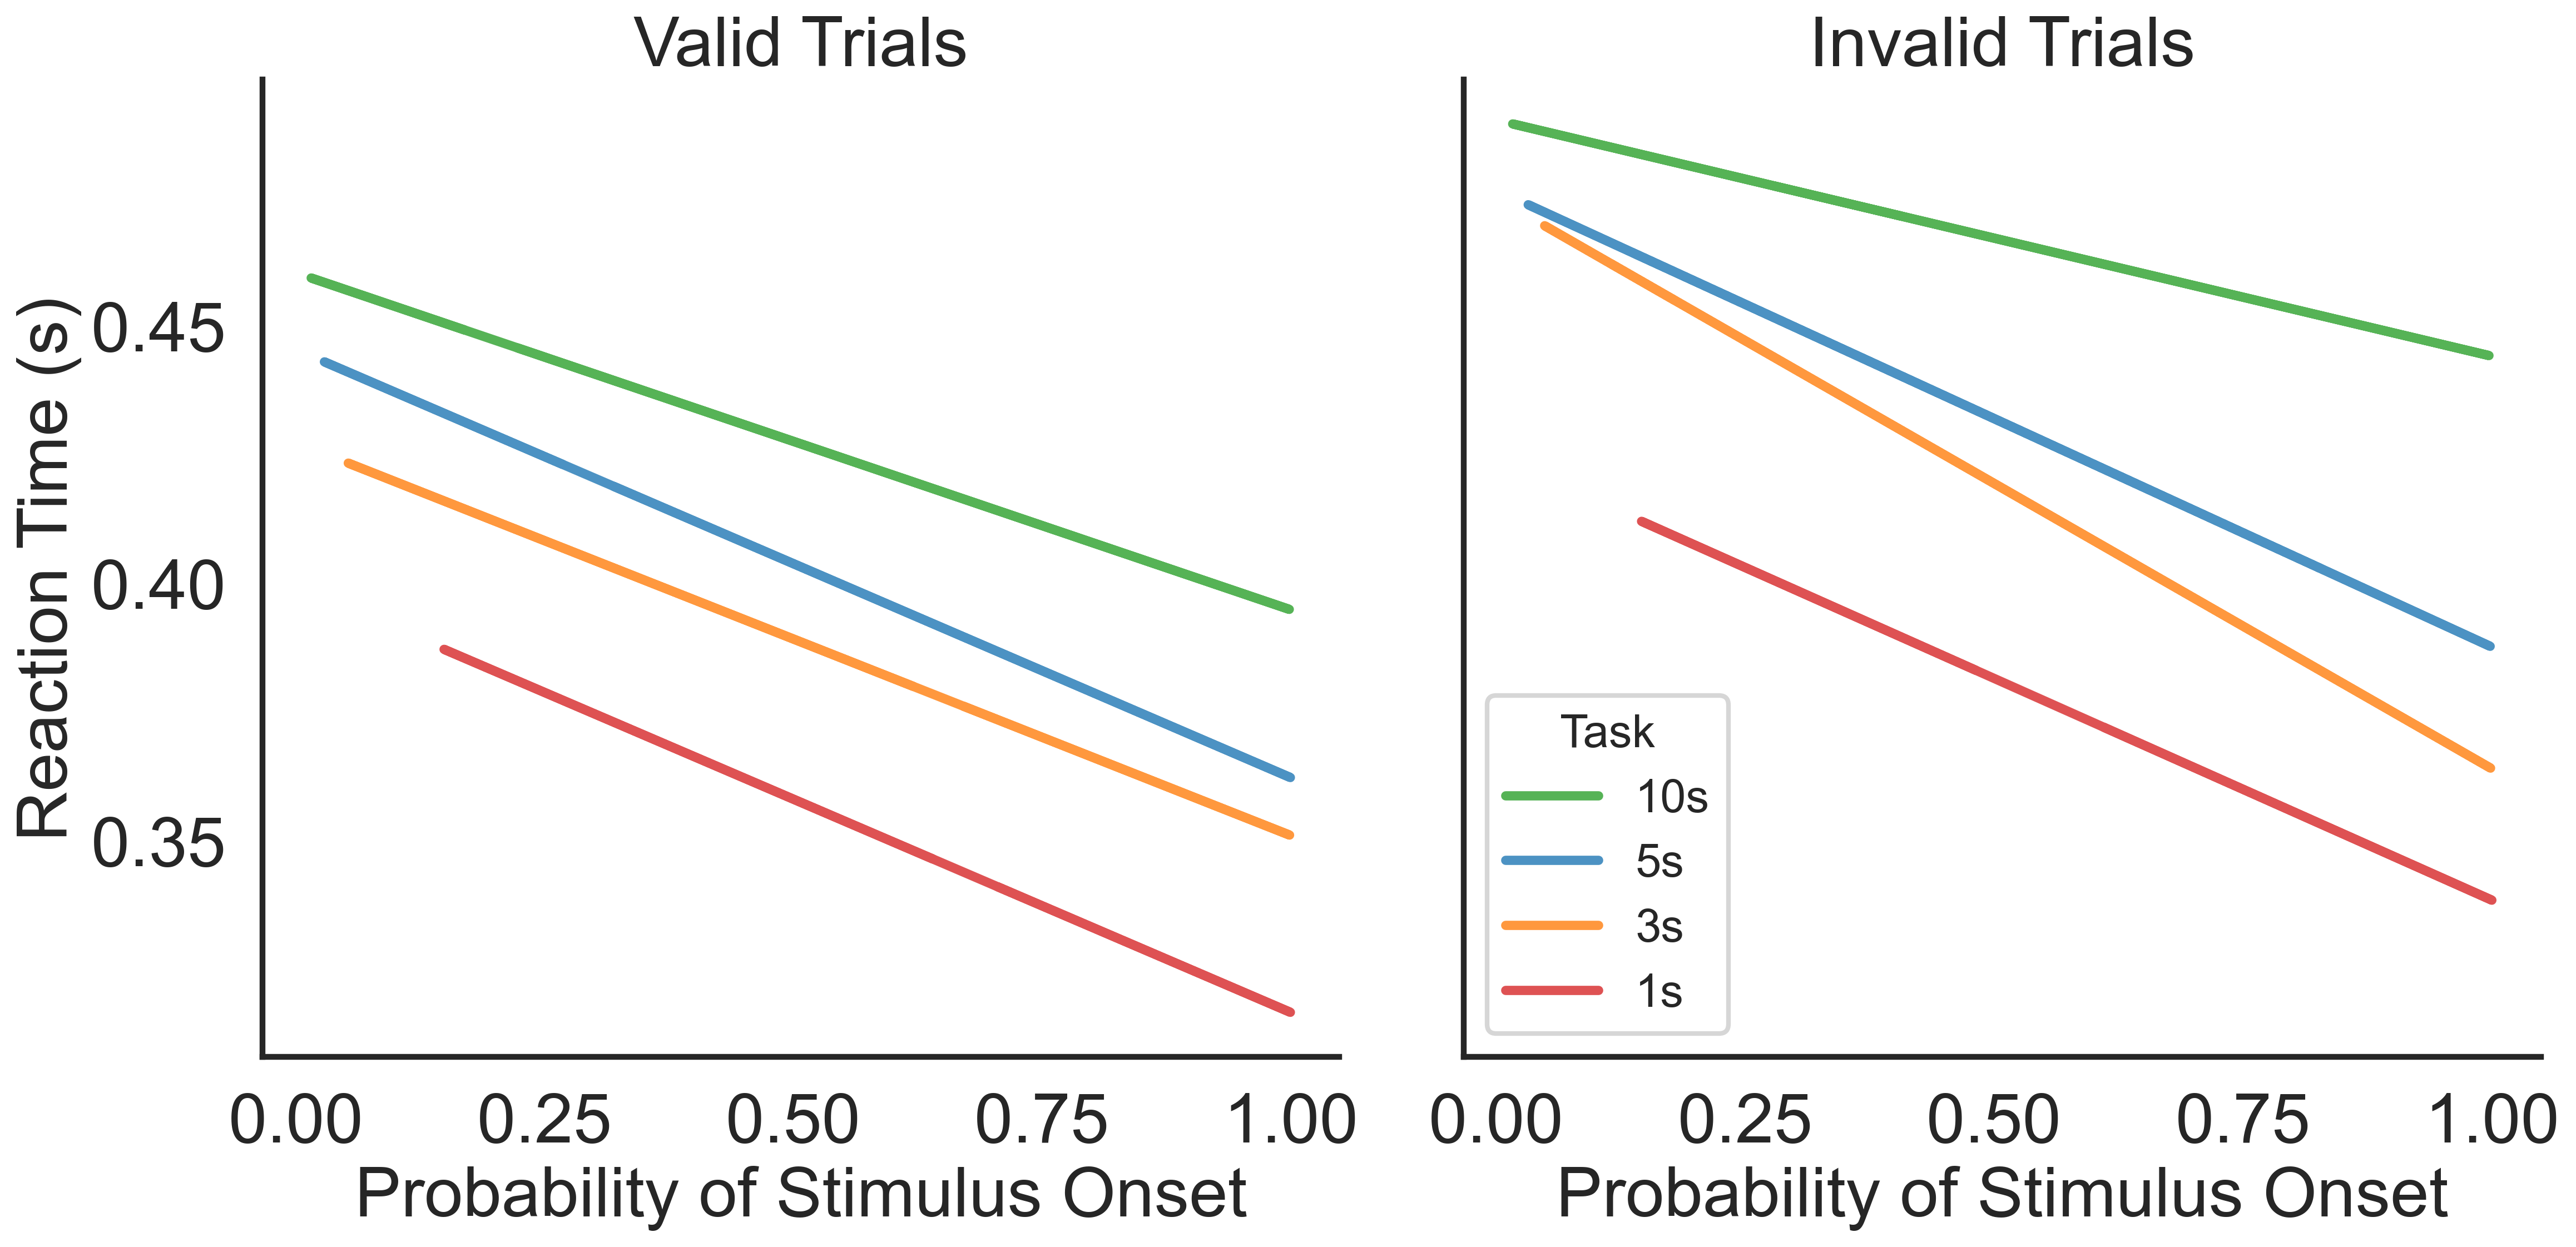

In [22]:
import matplotlib.ticker as mticker

# Define the two trial types
trial_types = [0, 1]  # 0 for congruent (Valid), 1 for incongruent (Invalid)
base_cond_nums = [1, 3, 5, 10]
legend_order = [10, 5, 3, 1]  # Legend ordering
colors = {'10s': 'tab:green', '5s': 'tab:blue', '3s': 'tab:orange', '1s': 'tab:red'}  # Color mapping for conditions
s1 = 30
s2 = 20

# Create subplots: 1 row, 2 columns (one for each trial type)
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True, dpi=300)

# Iterate over each trial type
for i, trial_type in enumerate(trial_types):
    ax = axes[i]  # Get the current axis for plotting
    l = 'Valid' if trial_type == 0 else 'Invalid'
    
    lines = []  # To store line objects for legend
    labels = []  # To store labels for legend
    
    # Iterate over each base condition number
    for base_cond_num in base_cond_nums:
        base_cond_str = str(base_cond_num) + 's'

        # Extract data for the given base condition number
        condition_data = full_dat[(full_dat['congruent'] == trial_type) & (full_dat['block_num'] == base_cond_str)]
        
        y_data = condition_data[condition_data['key_resp.rt'] >= min_log_rt_threshold]

        # Normalize x_data by the base condition number or get probabilities
        x_data = get_probs_for_dat(condition_data['Rand Tim'], base_cond_num)
        y_data = condition_data['key_resp.rt'].values
        


        # Fit model (assuming fit_model_norm is a function that fits a linear model)
        b_coef, b_int = fit_model_norm(x_data, y_data)

        # Plot the fit model line on the corresponding axis and store line objects
        line, = ax.plot(x_data, b_coef * x_data + b_int, color=colors[base_cond_str], linewidth=4, alpha=0.8, label=f'{base_cond_num}s')
        lines.append(line)  # Store the line object
        labels.append(f'{base_cond_num}s')  # Store the corresponding label
        
        # Set tick label sizes for x and y axes
        ax.tick_params(axis='x', labelsize=s1)
        ax.tick_params(axis='y', labelsize=s1)
        
        # Format x-axis tick labels to show only 2 decimal places
        ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
    
    # Set labels and title for each subplot
    ax.set_title(f'{l} Trials', fontsize=s1)
    ax.set_xlabel('Probability of Stimulus Onset', fontsize=s1)
    if i == 0:
        ax.set_ylabel('Reaction Time (s)', fontsize=s1)  # Add y-label to the first subplot only

    # Reorder legend to match the desired order, but only add the legend to the second plot
    if i == 1:  # Add legend only on the second subplot (i.e., Invalid)
        reordered_lines = [lines[base_cond_nums.index(num)] for num in legend_order]
        reordered_labels = [labels[base_cond_nums.index(num)] for num in legend_order]
        ax.legend(reordered_lines, reordered_labels, title='Task', fontsize='small', title_fontsize='small')

# Add space between subplots and adjust layout
plt.tight_layout()
sns.despine()
plt.savefig('probability_norm_fig.png')
plt.show()


# Sliding window ## 

In [52]:
def get_binned_rt(dat_con, dat_inc, intervals):
    '''
    return reaction times averaged per bin
    '''
    avs_con = []
    avs_incon = []
    for i in range(1,len(intervals)):
        av_con = dat_con['key_resp.rt'][(dat_con['Rand Tim']>intervals[i-1]) & (dat_con['Rand Tim']<intervals[i])].mean()
        av_inc = dat_inc['key_resp.rt'][(dat_inc['Rand Tim']>intervals[i-1]) & (dat_inc['Rand Tim']<intervals[i])].mean()
        #print("LB",intervals[i-1],"UB",intervals[i])
        #print('count_con:',len(dat_con['key_resp.rt'][(dat['Rand Tim']>intervals[i-1]) & (dat_con['Rand Tim']<intervals[i])]))
        #print('count_in:',len(dat_inc['key_resp.rt'][(dat_inc['Rand Tim']>intervals[i-1]) & (dat_inc['Rand Tim']<intervals[i])]))   
        avs_con.append(av_con)
        avs_incon.append(av_inc)
    return avs_con, avs_incon

def get_sliding_w_data(x_dat, y_dat, start, end, max_len, step):
    x_plot = []
    y_plot = []
    x_point = 0
    #while end < max_len:
    while x_point < max_len-step:
        ind = np.where((x_dat > start) & (x_dat < end))[0]
        y_plot.append(np.mean(y_dat[ind]))
        x_point = (start+ end) / 2
        x_plot.append(x_point)
        start += step
        end += step

    # last window
    ind = np.where((x_dat > start) & (x_dat < end))[0]
    y_plot.append(np.mean(y_dat[ind]))
    x_plot.append((start+ end) / 2)
    return x_plot, y_plot



In [47]:
def fit_partial_model(data, cond_len):
    # Define the predictor (X) and dependent variable (y)
    X = np.array(data['Rand Tim'][data['Rand Tim'] > (cond_len / 2)]).reshape(-1, 1)
    #y = data['key_resp.rt'] >5
    y = data['key_resp.rt'][data['Rand Tim'] > (cond_len / 2)]

    # Initialize and fit the linear regression model
    model = LinearRegression()
    model.fit(X, y)
    
    return X, model.coef_, model.intercept_

def custom_round_ticks(x_ticks):
    # Round each tick to one decimal place only if there's a decimal part
    return [f"{tick:.1f}".rstrip('0').rstrip('.') for tick in x_ticks]

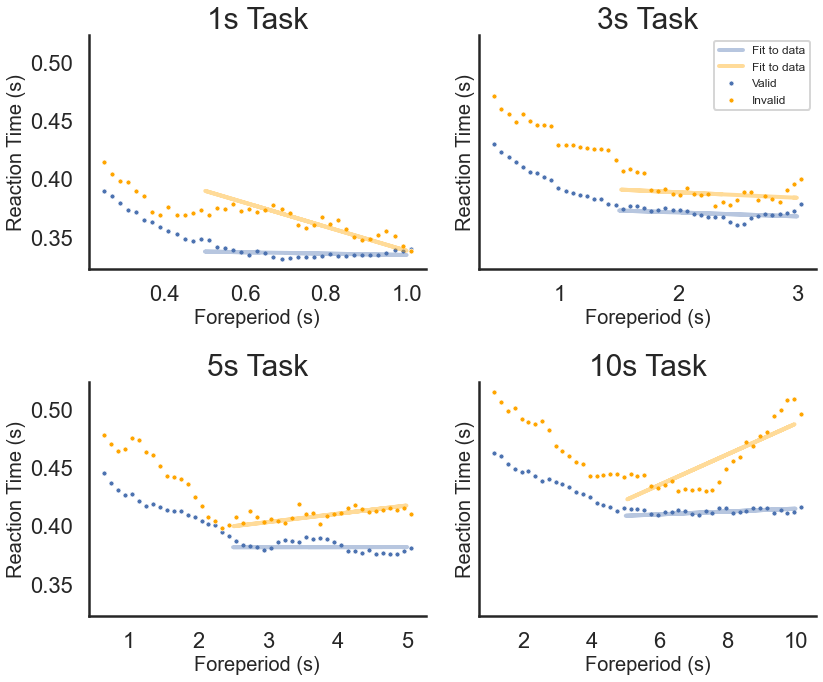

In [54]:
target_conditions = [1, 3, 5, 10]
sname = 'sliding_window.png'

# Create a 2x2 subplot grid for each target condition number
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
avs_con = []
avs_incon = []
x_vals = []

# Iterate over each target condition number
for i, targ_cond_num in enumerate(target_conditions):
    avs_con = []
    avs_incon = []
    x_vals = []
    
    row = i // 2  # Calculate the row index
    col = i % 2   # Calculate the column index
    
    targ_cond_str = str(targ_cond_num)+'s'

    dat_con = full_dat[(full_dat['congruent'] == 0) & (full_dat['block_num'] == targ_cond_str)]
    dat_inc = full_dat[(full_dat['congruent'] == 1) & (full_dat['block_num'] == targ_cond_str)]
    
    ## fit partial model ## 
    c_x_data, c_beta, c_int = fit_partial_model(dat_con, targ_cond_num)
    i_x_data, i_beta, i_int = fit_partial_model(dat_inc, targ_cond_num)

    # Get sliding window data 
    max_len = targ_cond_num
    i_len = targ_cond_num * .2 # length of bin size -- should be 10%
    start = .15
    end = start + i_len
    step = targ_cond_num * .02
    
    # DATA CON #
    x_dat = np.array(dat_con['Rand Tim'])
    y_dat = np.array(dat_con['key_resp.rt'])
    x_plot, y_plot = get_sliding_w_data(x_dat, y_dat, start, end, max_len, step)

    # Create scatter plot with reduced point size
    sns.scatterplot(x=x_plot, y=y_plot, label='Valid', ax=axes[row, col], color='b',s=25, legend=False)

    # DATA INC #
    x_dat = np.array(dat_inc['Rand Tim'])
    y_dat = np.array(dat_inc['key_resp.rt'])
    x_plot, y_plot = get_sliding_w_data(x_dat, y_dat, start, end, max_len, step)

    # Create scatter plot with reduced point size
    sns.scatterplot(x=x_plot, y=y_plot, label='Invalid', ax=axes[row, col], color='orange', s=25, legend=False)
    
    ## create lines of fit
    x_data = c_x_data.reshape(1,-1).flatten()
    axes[row, col].plot(x_data, c_beta[0] * x_data + c_int, color='b', linestyle='-', linewidth=4, alpha=.4, label='Fit to data')

    x_data = i_x_data.reshape(1,-1).flatten()
    axes[row, col].plot(x_data, i_beta[0] * x_data + i_int, color='orange', linestyle='-', linewidth=4, alpha=.4, label='Fit to data')

    
    # Set title and labels
    axes[row, col].set_title(f'{targ_cond_num}s Task', fontsize=30)
    axes[row, col].set_xlabel('Foreperiod (s)', fontsize=20)
    axes[row, col].set_ylabel('Reaction Time (s)', fontsize=20)
    
   # Only show legend in top right subplot
    if i == 1:
        axes[row, col].legend(loc='upper right', fontsize=12)

# Adjust layout
plt.tight_layout()

# Increase tick label font size
#plt.xticks(fontsize=10)
#plt.yticks(fontsize=10)
sns.despine()
#plt.savefig(sname)

# Show plot
plt.show()

# Sequence

In [56]:
# Get data file names
cur_path = os.getcwd()
filenames = glob.glob(cur_path + "/data/*.csv")
# Read dframes into a list
dfs = []
for filename in filenames:
    dfs.append(pd.read_csv(filename))

In [68]:
full_dat = pd.concat(filt_dfs)

# get first dataframe and filter columns

filt_dfs = []
# concat all dframes into one dframe
for sub_num, d in enumerate(dfs):
    my_df = d.filter(items=['congruent', 'Rand Tim', 'key_resp.rt','block_num'])
    my_df['subject_number'] = [sub_num] * len(my_df)  # Add subject number to the DataFrame

    # drop na, only 10s
    filt_dfs.append(my_df.dropna())

## concat #
full_dat = pd.concat(filt_dfs)



In [60]:
# Sort just in case (important when multiple subjects exist)
#df = full_dat.sort_values(['subject_number']).reset_index(drop=True)
# Sort just in case (important when multiple subjects exist)
df = full_dat

# Group by subject and compare Rand Tim to previous trial
df['previous Rand Tim'] = df.groupby('subject_number')['Rand Tim'].shift(1)
df['previous trial'] = (df['Rand Tim'] >= df['previous Rand Tim']).astype(int) ## 0 is longer before, 1 is shorter before

# Drop the first trial per subject (no previous trial)
df = df.dropna(subset=['previous Rand Tim']).reset_index(drop=True)

# Optional: drop the helper column if you no longer need it
df = df.drop(columns='previous Rand Tim')
df

congruent  Rand Tim  key_resp.rt block_num  subject_number  \
0           1.0    0.7037     0.709031        5s               0   
1           0.0    0.8309     0.434464        5s               0   
2           1.0    4.6764     0.553009        5s               0   
3           0.0    4.6441     0.518856        5s               0   
4           0.0    3.2655     0.552214        5s               0   
...         ...       ...          ...       ...             ...   
9319        1.0    4.1302     0.473883        5s              25   
9320        0.0    4.1825     0.864461        5s              25   
9321        0.0    3.5785     0.386026        5s              25   
9322        0.0    1.9596     0.395578        5s              25   
9323        0.0    1.5706     0.367873        5s              25   

      previous trial  
0                  0  
1                  1  
2                  1  
3                  0  
4                  0  
...              ...  
9319               1  
9320               1  
9321               0  
9322               0  
9323               0  

[9324 rows x 6 columns]

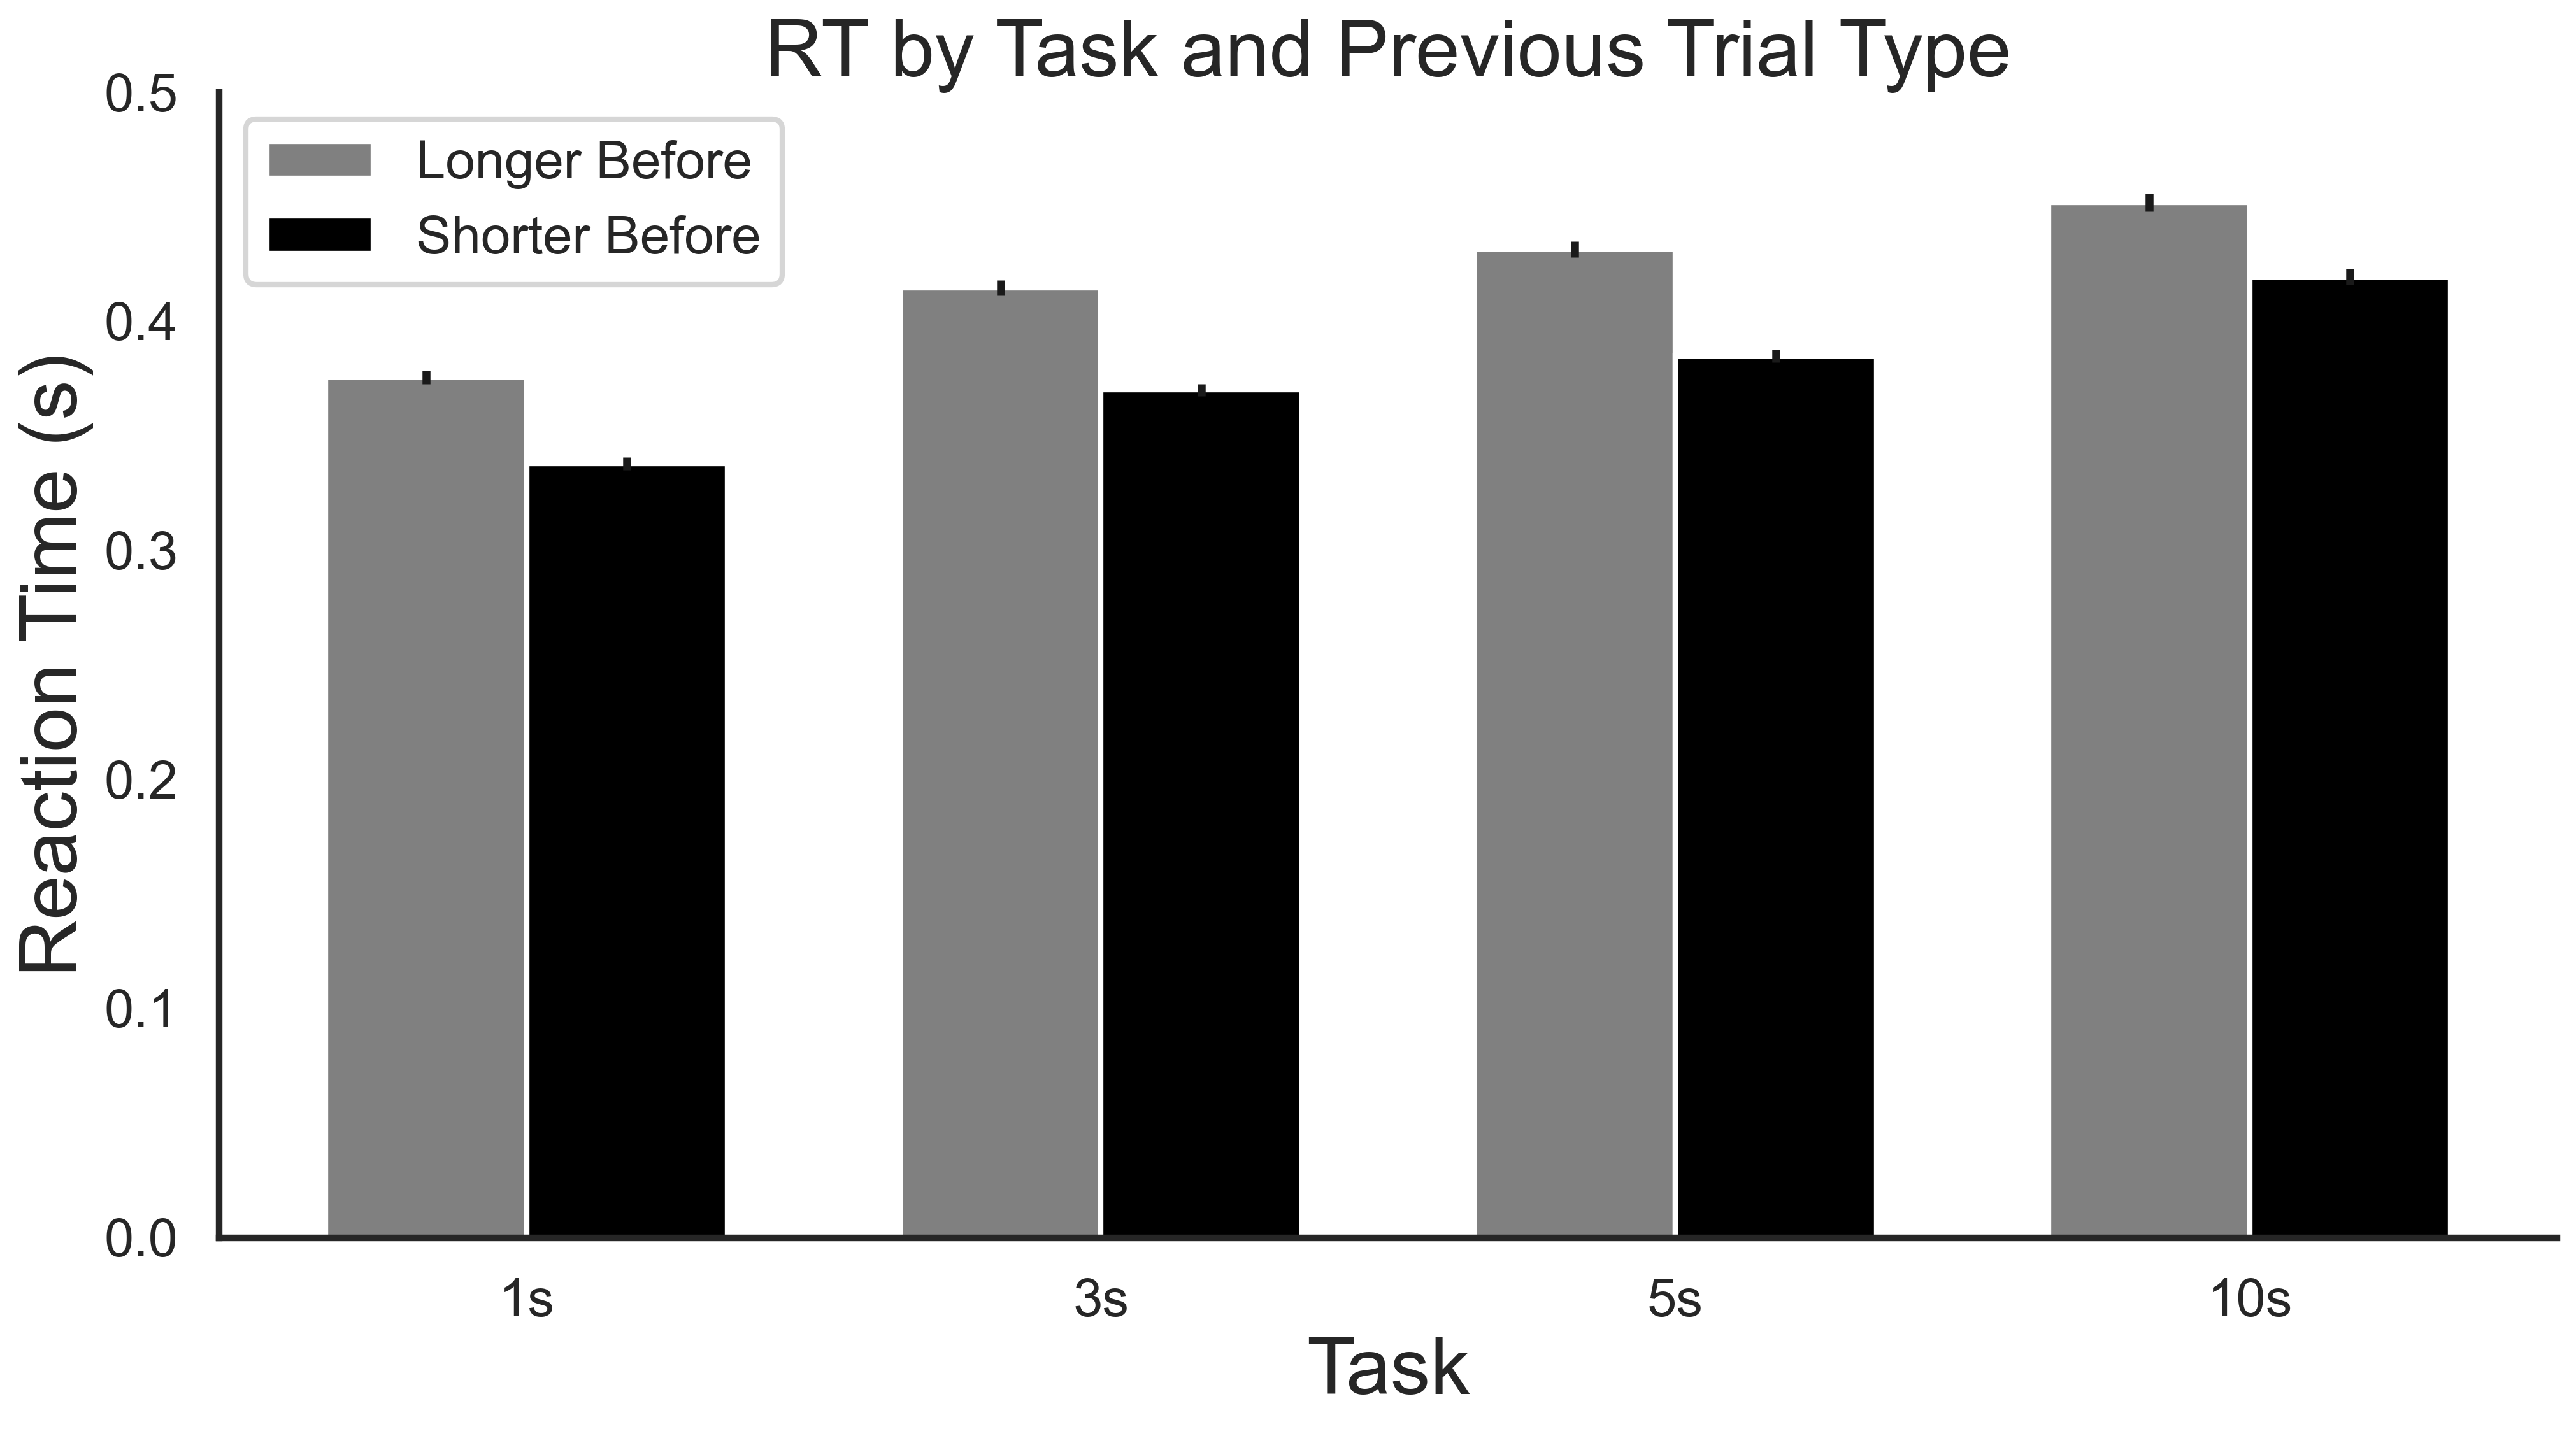

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings
sns.set(style="white")
sns.set_context("poster")

# Trial categories: 0 = previous trial longer, 1 = previous trial shorter
prev_labels = ['Longer Before', 'Shorter Before']
conditions = ['1s', '3s', '5s', '10s']
legend_order = ['10s', '5s', '3s', '1s']
colors = {'10s': 'tab:green', '5s': 'tab:blue', '3s': 'tab:orange', '1s': 'tab:red'}

s1 = 30  # font size large
s2 = 20  # font size medium

# Prepare data for barplot
bar_heights = []
bar_errors = []

for cond in conditions:
    cond_means = []
    cond_sems = []
    for prev_val in [0, 1]:  # 0 = longer before, 1 = shorter before
        subset = df[(df['block_num'] == cond) & (df['previous trial'] == prev_val)]
        if subset.empty:
            cond_means.append(np.nan)
            cond_sems.append(np.nan)
        else:
            rt_vals = subset['key_resp.rt'].values
            cond_means.append(np.mean(rt_vals))
            cond_sems.append(np.std(rt_vals) / np.sqrt(len(rt_vals)))  # SEM

    bar_heights.append(cond_means)
    bar_errors.append(cond_sems)

# Convert to NumPy arrays for easier plotting
bar_heights = np.array(bar_heights)  # shape (num_conditions, 2)
bar_errors = np.array(bar_errors)

# Set up plot
fig, ax = plt.subplots(figsize=(14, 8), dpi=300)
x = np.arange(len(conditions))  # the label locations
width = 0.35  # width of the bars

# Plot bars
bars1 = ax.bar(x - width/2, bar_heights[:, 0], width, label='Longer Before', color='gray', yerr=bar_errors[:, 0])
bars2 = ax.bar(x + width/2, bar_heights[:, 1], width, label='Shorter Before', color='black', yerr=bar_errors[:, 1])

# Labels and ticks
ax.set_ylabel('Reaction Time (s)', fontsize=s1)
ax.set_xlabel('Task', fontsize=s1)
ax.set_title('RT by Task and Previous Trial Type', fontsize=s1)
ax.set_xticks(x)
ax.set_xticklabels(conditions, fontsize=s2)
ax.tick_params(axis='y', labelsize=s2)
ax.set_ylim(top=0.5)

ax.legend(fontsize=s2, title_fontsize=s2)

sns.despine()
plt.tight_layout()
plt.savefig('seq_effect_bars_hum.png')

plt.show()


## Binned

In [85]:

sns.set(style="white")
sns.set_context("poster")

# Trial categories: 0 = previous trial longer, 1 = previous trial shorter
prev_trial_vals = [0, 1]
titles = ['When the previous trial was\nLONGER', 'When the previous trial was\nSHORTER']
conditions = ['1s', '3s', '5s', '10s']
legend_order = ['10s', '5s', '3s', '1s']
colors = {'10s': 'tab:green', '5s': 'tab:blue', '3s': 'tab:orange', '1s': 'tab:red'}

s1 = 30  # font size large
s2 = 20  # font size medium

# Helper function to get binned RTs
def get_binned_rt(data, intervals):
    avs, se = [], []
    for i in range(1, len(intervals)):
        bin_data = data['key_resp.rt'][(data['Rand Tim'] > intervals[i - 1]) & (data['Rand Tim'] < intervals[i])]
        avs.append(bin_data.mean())
        se.append(bin_data.std() / np.sqrt(len(bin_data)) if len(bin_data) > 1 else np.nan)
    return np.array(avs), np.array(se)

def get_sliding_window_rt(subset, window_size=0.1, step_size=0.02, start=0.15):
    """
    Compute mean and SEM of RTs using a sliding window across normalized onset times.
    
    Parameters:
    - subset: DataFrame containing 'Rand Tim' and 'key_resp.rt'
    - window_size: width of the sliding window (in normalized units)
    - step_size: step between windows (in normalized units)
    - start: starting point for the first window (in normalized units)
    
    Returns:
    - x_vals: center of each window (normalized)
    - means: mean RTs per window
    - sems: SEM of RTs per window
    """
    norm_onset = subset['Rand Tim'] / subset['block_num'].astype(str).str.rstrip('s').astype(float)
    rt = subset['key_resp.rt']
    
    x_vals = []
    means = []
    sems = []
    
    current_start = start
    while current_start + window_size <= 1.0:
        current_end = current_start + window_size
        in_window = (norm_onset >= current_start) & (norm_onset < current_end)
        window_rts = rt[in_window]
        
        if len(window_rts) > 1:
            x_vals.append((current_start + current_end) / 2)
            means.append(window_rts.mean())
            sems.append(window_rts.std() / np.sqrt(len(window_rts)))
        
        current_start += step_size
    
    return np.array(x_vals), np.array(means), np.array(sems)

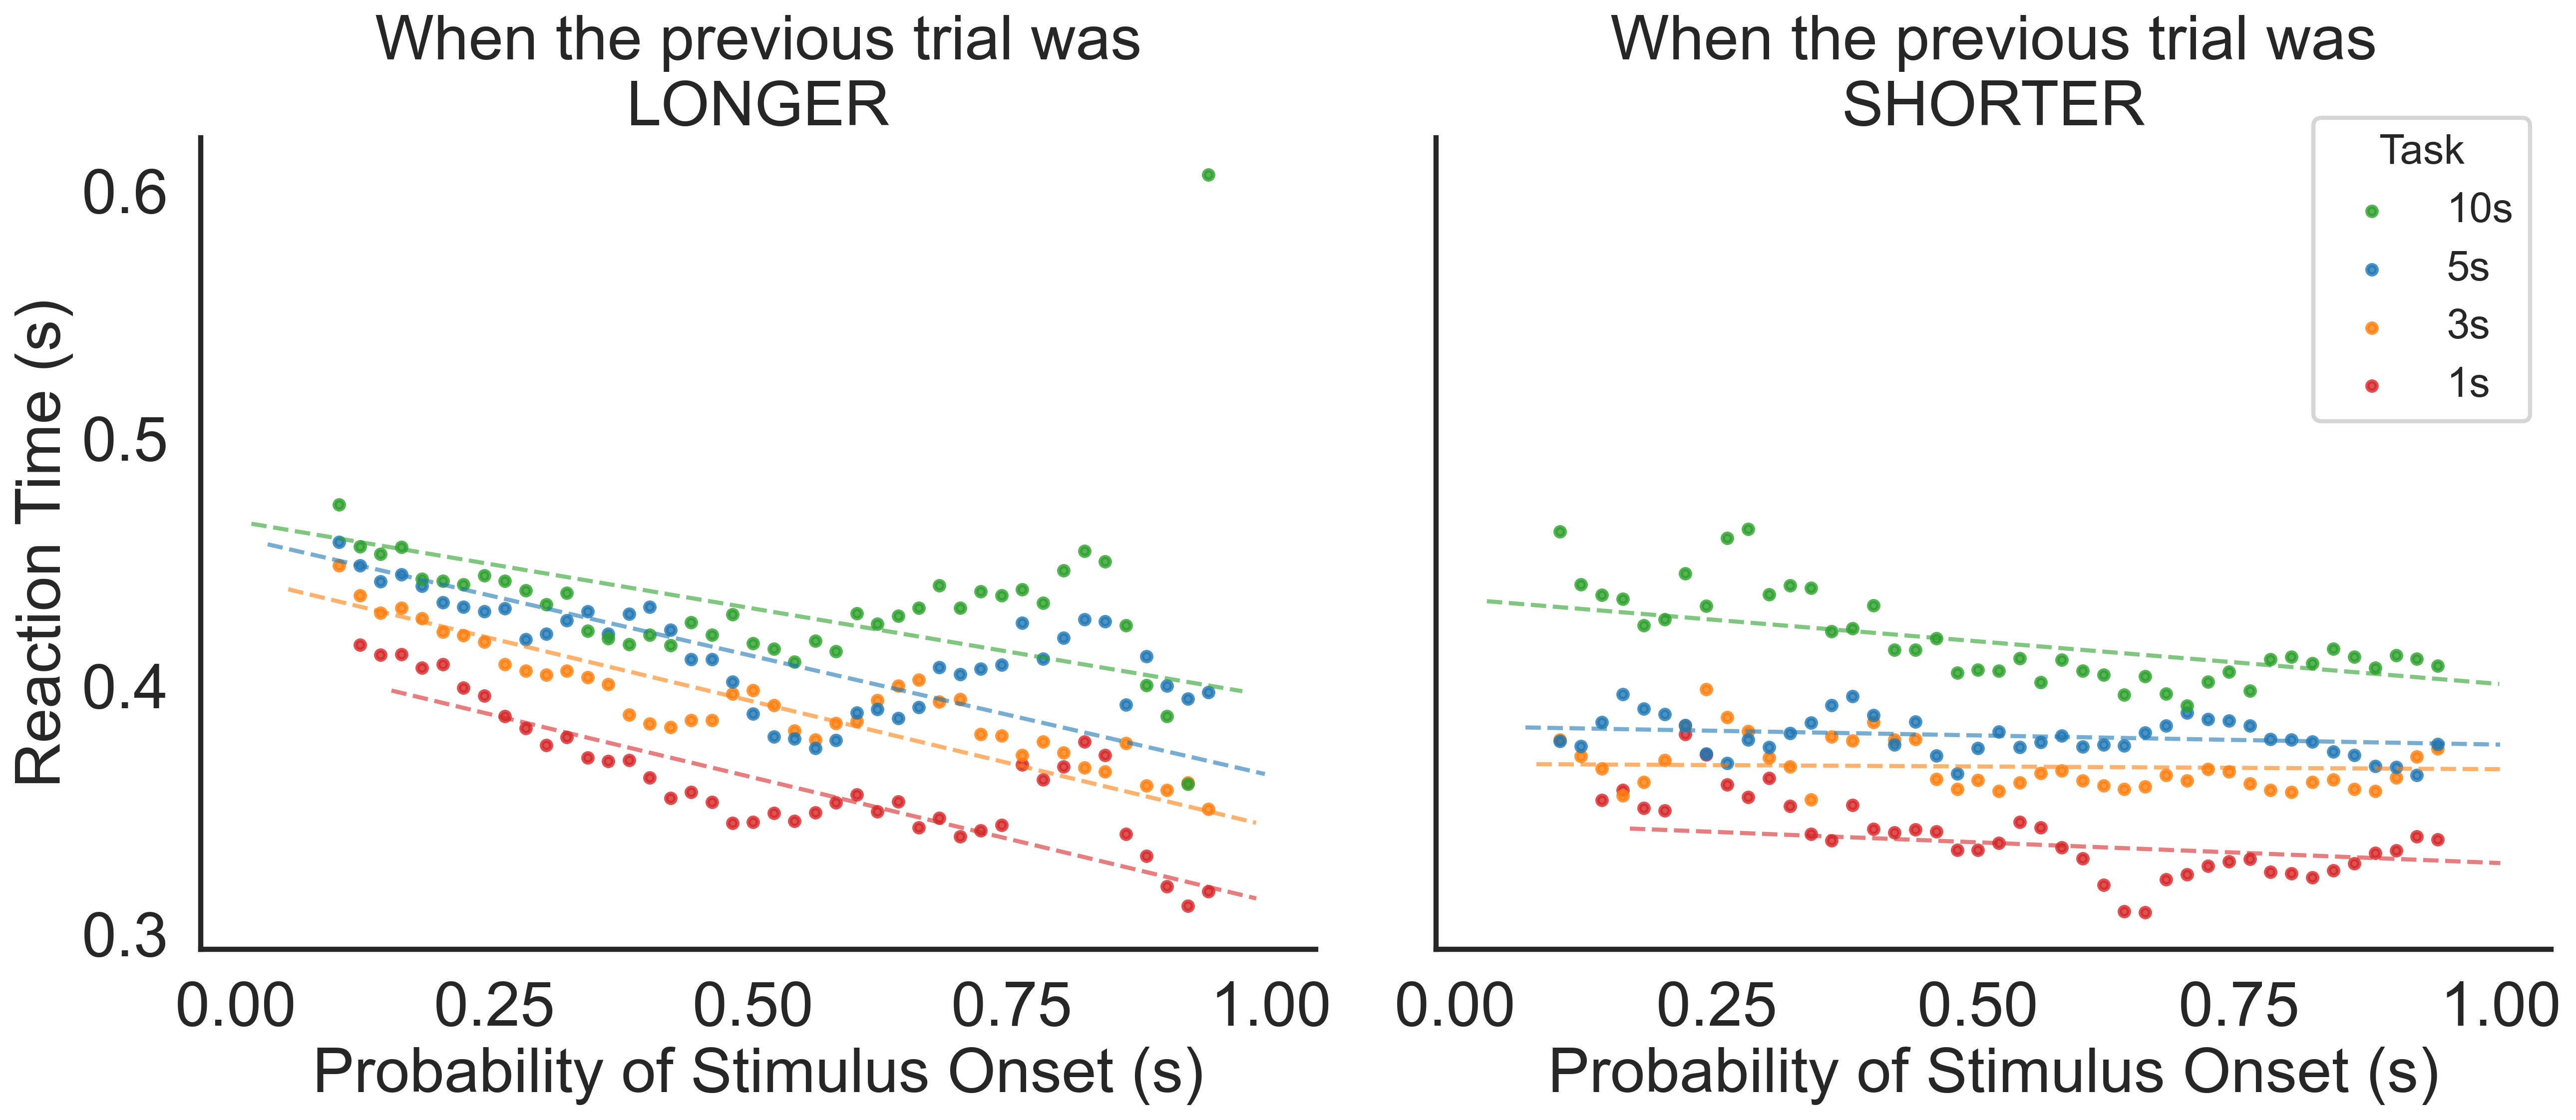

In [93]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True, dpi=300)

# Iterate over trial categories
for i, prev_val in enumerate(prev_trial_vals):
    ax = axes[i]

    for cond in conditions:
        color = colors[cond]
        subset = df[(df['block_num'] == cond) & (df['previous trial'] == prev_val) & (df['congruent'] == 0)]
        #subset = df[(df['block_num'] == cond) & (df['previous trial'] == prev_val)]

        if subset.empty:
            continue

        cond_num = int(cond[:-1])
        onset = subset['Rand Tim'].values / cond_num

        x_vals, means, sems = get_sliding_window_rt(subset, window_size=0.1, step_size=0.02, start=0.05)
        ax.scatter(x_vals, means, color=color, label=cond, alpha=0.8,s=20)

        # Fit regression line on original (non-binned) data
        onset = subset['Rand Tim'].values.reshape(-1, 1) / int(cond[:-1])  # Normalize onset
        rt = subset['key_resp.rt'].values.reshape(-1, 1)

        if len(onset) > 1:  # avoid fitting on too few points
            reg = LinearRegression().fit(onset, rt)
            x_line = np.linspace(onset.min(), onset.max(), 100).reshape(-1, 1)
            y_line = reg.predict(x_line)
            ax.plot(x_line, y_line, color=color, linestyle='--', linewidth=2, alpha=0.6)

        ax.tick_params(axis='x', labelsize=s1)
        ax.tick_params(axis='y', labelsize=s1)
        ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

    ax.set_title(titles[i], fontsize=s1)
    ax.set_xlabel('Probability of Stimulus Onset (s)', fontsize=s1)
    if i == 0:
        ax.set_ylabel('Reaction Time (s)', fontsize=s1)

    if i == 1:
        handles, labels = ax.get_legend_handles_labels()
        reordered_handles = [handles[conditions.index(cond)] for cond in legend_order if cond in conditions]
        reordered_labels = [labels[conditions.index(cond)] for cond in legend_order if cond in conditions]
        ax.legend(reordered_handles, reordered_labels, title='Task', fontsize='small', title_fontsize='small',
                  loc='upper right', bbox_to_anchor=(1, 1.05))

plt.tight_layout()
sns.despine()
plt.savefig('seq_effect_binned_rt_VAL-hum.png')
plt.show()
